# Classification - Determine International Rating 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import math
import re
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Step 1. Prepare data

X:  (3563, 56)
1.0    3236
2.0     262
3.0      53
4.0      12
Name: International Reputation, dtype: int64
n_classes:  4


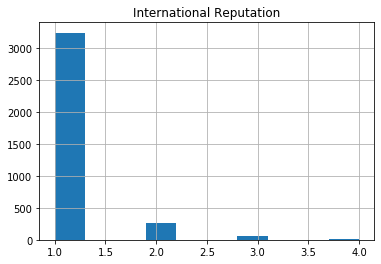

In [3]:
from sklearn.preprocessing import label_binarize

# Read original data
sample_data = pd.read_csv('fifa19_ready_data.csv', encoding='utf-8')
# Remove ID
sample_data = sample_data.drop('ID', axis=1)
# Separate internation rating result with rest
y = sample_data['International Reputation']
X = sample_data.drop('International Reputation', axis=1)
print('X: ', X.shape)

# Binarize the rating result
# Rating score 5 records is only 6 / 18208, so it cannot be predicated with too little data,
# we convert the score 5 to 4, so only choose rating scores 1, 2, 3, 4 to classify.
sample_data['International Reputation'].loc[sample_data['International Reputation'] == 5] = 4
sample_data.hist(column='International Reputation')
print(sample_data['International Reputation'].value_counts())

y = label_binarize(y, classes=[1, 2, 3, 4])
n_classes = y.shape[1]
print('n_classes: ', n_classes)

X_train:  (2375, 56) X_test:  (1188, 56)
Rating Score value counts:  1
1    2162
0     213
dtype: int64


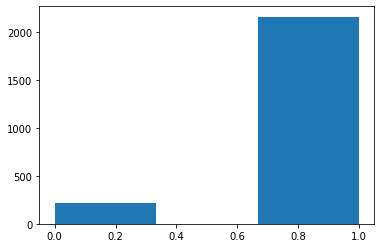

 
Rating Score value counts:  2
0    2203
1     172
dtype: int64


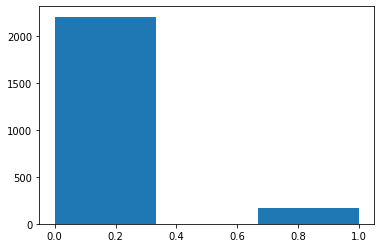

 
Rating Score value counts:  3
0    2343
1      32
dtype: int64


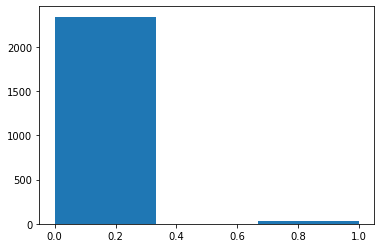

 
Rating Score value counts:  4
0    2366
1       9
dtype: int64


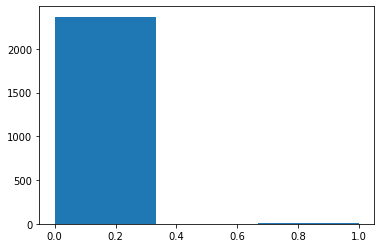

In [4]:
# Divide data into training set and testing set
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=1/3,random_state=1)
print('X_train: ', X_train.shape, 'X_test: ', X_test.shape)

#print(y_train)
for i in range(n_classes):
    print("Rating Score value counts: ", i + 1)
    print(pd.value_counts(y_train[:, i]))
    plt.hist(y_train[:, i], bins=3)
    plt.show()
    print(" ")


In [5]:
# Standardize records
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 
print('X_train: ', X_train.shape, 'X_test: ', X_test.shape)

X_train:  (2375, 56) X_test:  (1188, 56)


In [6]:
# Step 2. Solve with Logistic Regression

In [7]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, make_scorer
from scipy import interp
from itertools import cycle

# Create function to store ROC computation results for all classification classes
def compute_roc_auc_in_classes(test_data, test_result, num_classes=n_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    roc_result = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc }
    
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(test_data[:, i], test_result[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(test_data.ravel(), test_result.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    # Compute macro-average ROC curve and ROC area
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    return roc_result

# Draw ROC plot based on ROC computation result
def draw_roc_auc_in_classes(roc_auc_result, learn_method, num_classes=n_classes):
    fpr = roc_auc_result['fpr']
    tpr = roc_auc_result['tpr']
    roc_auc = roc_auc_result['roc_auc']
    
    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["macro"], tpr["macro"],
             label='Average ROC (area = {0:0.4f})'.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=1,
                 label='ROC of rating {0} (area = {1:0.4f})'.format((i + 1), roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for {}'.format(learn_method))
    plt.legend(loc="lower right")
    plt.show()
    

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# create logistic regression model for multi-class and one vs rest mode
logreg = OneVsRestClassifier(LogisticRegression(solver='sag', multi_class='ovr', random_state=1))
#print("parameters: ", logreg.get_params().keys())

# Create GridSearch to find best model
penalty_param = ['l2']
solver_param = ['sag', 'saga']
C_param = [0.0001, 0.001, 0.01, 1, 50, 100, 200, 1000]
hyperparameters = dict(estimator__C=C_param, estimator__penalty=penalty_param, estimator__solver=solver_param)

# Fit model using gridsearch
score_making_func = make_scorer(roc_auc_score, average='macro')
grid_logreg = GridSearchCV(logreg, hyperparameters, scoring = score_making_func, verbose=0)

# Best model
best_logreg = grid_logreg.fit(X_train, y_train)

#Print all the Parameters that gave the best results:
print('Best Parameters', grid_logreg.best_params_)

Best Parameters {'estimator__C': 50, 'estimator__penalty': 'l2', 'estimator__solver': 'sag'}


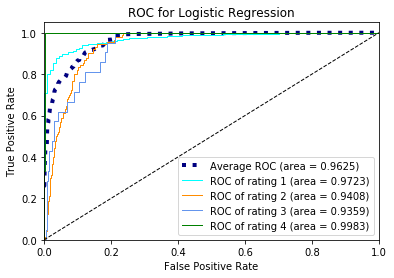

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

# Compute test scores
y_score = best_logreg.fit(X_train, y_train).decision_function(X_test)

# Compute ROC AUC score
logreg_result = compute_roc_auc_in_classes(y_test, y_score, num_classes=n_classes)

# Draw ROC plot
draw_roc_auc_in_classes(logreg_result, 'Logistic Regression', num_classes=n_classes)


In [10]:
# Assign Best score
roc_logreg = logreg_result['roc_auc']['macro']
print("Best ROC score for logistic regression: {0:0.4f}".format(roc_logreg))

Best ROC score for logistic regression: 0.9625


In [11]:
# Step 3. Solve with Naive Bayes

In [12]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
import time

def show_time_spent(start_time):
    time_used = time.time() - start_time
    return "{}:{}:{}".format(int(time_used / 3600), int(time_used % 3600 / 60), int(time_used % 60))

kernel = 1.0 * RBF(1.0)

# create Naive Bayes model for multi-class and one vs rest mode
gaussian_proc = OneVsRestClassifier(GaussianProcessClassifier(kernel=kernel, multi_class='one_vs_rest', random_state=1))
print('Created gaussian_proc')
#print("parameters: ", gaussian_proc.get_params().keys())
#print(sorted(metrics.SCORERS.keys()))

# Create GridSearch to find best model
# Tested:
#    max_iter_param = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
#    warm_state_param = [ True, False ]
# And best parameters: {'estimator__max_iter_predict': 20, 'estimator__warm_start': False}
# So to save time, only run with best parameter
max_iter_param = [20]
warm_state_param = [ False ]
hyperparameters = dict(estimator__max_iter_predict=max_iter_param, estimator__warm_start=warm_state_param)

# Fit model using gridsearch
score_making_func = make_scorer(roc_auc_score, average='macro')
grid_gaussian_proc = GridSearchCV(gaussian_proc, hyperparameters, scoring=score_making_func, verbose=0)

Created gaussian_proc


In [13]:
# Compute test scores
timer_check = time.time()
print('start training')

# Best model
best_gaussian_proc = grid_gaussian_proc.fit(X_train, y_train)

#Print all the Parameters that gave the best results:
print('Best Parameters', grid_gaussian_proc.best_params_)

print('training spent: ', show_time_spent(timer_check))

start training
Best Parameters {'estimator__max_iter_predict': 20, 'estimator__warm_start': False}
training spent:  0:9:26


In [14]:
#timer_check = time.time()
print('start testing')
y_pred_proba = best_gaussian_proc.predict_proba(X_test)
#print('testing spent: ', show_time_spent(timer_check))
print('y_pred_proba: ', y_pred_proba.shape)

start testing
y_pred_proba:  (1188, 4)


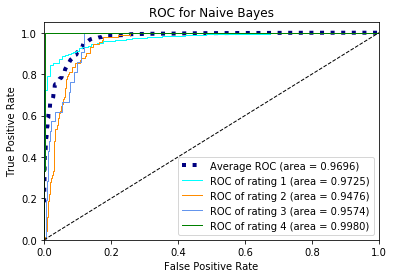

In [15]:
# Compute ROC AUC score
gaussion_proc_result = compute_roc_auc_in_classes(y_test, y_pred_proba, num_classes=n_classes)

# Draw ROC plot
draw_roc_auc_in_classes(gaussion_proc_result, 'Naive Bayes', num_classes=n_classes)

In [16]:
# Assign Best ROC value
roc_gaussian_proc = gaussion_proc_result['roc_auc']["macro"]
print('Best ROC score for Naive Bayes: {0:0.4f}'.format(roc_gaussian_proc))

Best ROC score for Naive Bayes: 0.9696


In [17]:
# Step 4. Solve with Decision Tree

In [18]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

# create Decision Tree model for multi-class and one vs rest mode
decision_tree = OneVsRestClassifier(BaggingClassifier(DecisionTreeClassifier(random_state=1), 
                                    bootstrap=True, oob_score = True, n_jobs=-1, random_state=1))
print('Created decision_tree')
#print("parameters: ", decision_tree.get_params().keys())

# Create GridSearch to find best model
# Tested: 
#    criterion_param = ['entropy', 'gini']
#    max_depth_param = [ 10, 20, 40]
#    max_leaf_nodes_param = [ 20, 50, 100 ]
#    max_features_param = [ 20, 40, X_train.shape[1]]
#    n_estimators_param = [ 100, 500, 1000 ]
#    max_samples_param = [ 100, 500, 1000 ]
#    Best Parameters {'estimator__base_estimator__criterion': 'gini', 
#                     'estimator__base_estimator__max_depth': 20, 
#                     'estimator__base_estimator__max_features': 56, 
#                     'estimator__base_estimator__max_leaf_nodes': 50, 
#                     'estimator__max_samples': 1000, 
#                     'estimator__n_estimators': 500}
# So to save time, only run with best parameters
criterion_param = [ 'gini']
max_depth_param = [ 20 ]
max_leaf_nodes_param = [ 50 ]
max_features_param = [ X_train.shape[1] ]
n_estimators_param = [ 500 ]
max_samples_param = [ 1000 ]

hyperparameters = dict(estimator__base_estimator__criterion=criterion_param, 
                       estimator__base_estimator__max_depth=max_depth_param,
                       estimator__base_estimator__max_leaf_nodes=max_leaf_nodes_param, 
                       estimator__base_estimator__max_features=max_features_param,
                       estimator__n_estimators=n_estimators_param,
                       estimator__max_samples=max_samples_param )

# Fit model using gridsearch
score_making_func = make_scorer(roc_auc_score, average='macro') 
grid_decision_tree = GridSearchCV(decision_tree, hyperparameters, scoring = score_making_func, verbose=0)
#print(sorted(metrics.SCORERS.keys()))

Created decision_tree


In [19]:
# Compute test scores
timer_check = time.time()
print('start training')

# Best model
best_decision_tree = grid_decision_tree.fit(X_train, y_train)

#Print all the Parameters that gave the best results:
print('Best Parameters', grid_decision_tree.best_params_)

# Compute test scores
y_pred_proba = best_decision_tree.predict_proba(X_test)
print('y_pred_proba: ', y_pred_proba.shape)

print('training spent: ', show_time_spent(timer_check))

start training
Best Parameters {'estimator__base_estimator__criterion': 'gini', 'estimator__base_estimator__max_depth': 20, 'estimator__base_estimator__max_features': 56, 'estimator__base_estimator__max_leaf_nodes': 50, 'estimator__max_samples': 1000, 'estimator__n_estimators': 500}
y_pred_proba:  (1188, 4)
training spent:  0:0:15


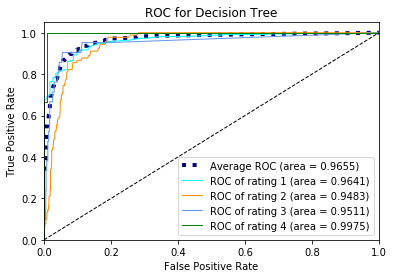

In [20]:
# Compute ROC AUC score
decision_tree_result = compute_roc_auc_in_classes(y_test, y_pred_proba, num_classes=n_classes)

# Draw ROC plot
draw_roc_auc_in_classes(decision_tree_result, 'Decision Tree', num_classes=n_classes)

In [21]:
# Assign Best ROC value
roc_decision_tree = decision_tree_result['roc_auc']["macro"]
print('Best ROC score for Decision Tree: {0:0.4f}'.format(roc_decision_tree))

Best ROC score for Decision Tree: 0.9655


In [22]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#DT visualizatin method 3
#!conda install -y pydotplus
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image, display
import pydotplus
import os
os.environ["PATH"] += os.pathsep + 'D:/App/Graphviz2.38/bin/'

def show_decision_tree(decision_tree_model, features, out_png_file='decision_tree.png', classes=['0', '1']):
    dot_data = StringIO()
    export_graphviz(decision_tree_model, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True,feature_names=features, class_names=classes)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    graph.write_png(out_png_file)
    img = Image(filename = out_png_file)
    display(img)

for i in range(n_classes):
    rating_score = i + 1
    out_png_file = 'decision_tree{}.png'.format(rating_score)
    items = best_decision_tree.best_estimator_.estimators_[i].estimators_
    print('First Decision Tree for rating score {0} ({1} Decision Tree(s))'.format(rating_score, len(items)))
    #show_decision_tree(items[0], X.columns, out_png_file=out_png_file)
    print("-----------")

First Decision Tree for rating score 1 (500 Decision Tree(s))
-----------
First Decision Tree for rating score 2 (500 Decision Tree(s))
-----------
First Decision Tree for rating score 3 (500 Decision Tree(s))
-----------
First Decision Tree for rating score 4 (500 Decision Tree(s))
-----------


In [23]:
# Step 5. Solve with SVM

In [24]:
from sklearn.svm import LinearSVC

# create model for multi-class and one vs rest mode
linear_svc = OneVsRestClassifier(BaggingClassifier(LinearSVC(multi_class='ovr', random_state=1), 
                                bootstrap=True, oob_score = True, n_jobs=-1, random_state=1))
print('Created SVM')
#print("parameters: ", linear_svc.get_params().keys())

# Create GridSearch to find best model
# Tested:
#    max_iter_param = [50, 100, 200, 500, 1000]
#    dul_param = [True, False]
#    C_param = [ 1, 4, 6, 10, 20 ]
#    fit_intercept_param  = [True, False]
#    n_estimators_param = [ 100, 500, 1000 ]
#    max_samples_param = [ 100, 500, 1000 ]
# Best Parameters {'estimator__base_estimator__C': 6, 
#                  'estimator__base_estimator__dual': True, 
#                  'estimator__base_estimator__fit_intercept': False, 
#                  'estimator__base_estimator__max_iter': 100, 
#                  'estimator__max_samples': 1000, 
#                  'estimator__n_estimators': 100}
# To save time, only run with best parameters
max_iter_param = [100]
dul_param = [True]
C_param = [ 6 ]
fit_intercept_param  = [False]
n_estimators_param = [ 100 ]
max_samples_param = [ 1000 ]

hyperparameters = dict(estimator__base_estimator__C=C_param, 
                       estimator__base_estimator__fit_intercept=fit_intercept_param,
                       estimator__base_estimator__dual=dul_param, 
                       estimator__base_estimator__max_iter=max_iter_param,
                       estimator__n_estimators=n_estimators_param,
                       estimator__max_samples=max_samples_param )

# Fit model using gridsearch
score_making_func = make_scorer(roc_auc_score, average='macro')
grid_linear_svc = GridSearchCV(linear_svc, hyperparameters, scoring=score_making_func, verbose=0)

Created SVM


In [25]:
timer_check = time.time()
print('start training')

# Best model
best_linear_svc = grid_linear_svc.fit(X_train, y_train)

#Print all the Parameters that gave the best results:
print('Best Parameters', grid_linear_svc.best_params_)

print('training spent: ', show_time_spent(timer_check))

# Compute test scores
y_pred = best_linear_svc.predict(X_test)
print('y_pred: ', y_pred.shape)

start training
Best Parameters {'estimator__base_estimator__C': 6, 'estimator__base_estimator__dual': True, 'estimator__base_estimator__fit_intercept': False, 'estimator__base_estimator__max_iter': 100, 'estimator__max_samples': 1000, 'estimator__n_estimators': 100}
training spent:  0:0:15
y_pred:  (1188, 4)


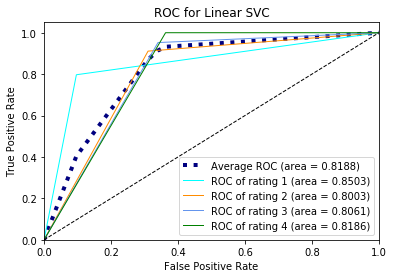

In [26]:
# Compute ROC AUC score
linear_svc_result = compute_roc_auc_in_classes(y_test, y_pred, num_classes=n_classes)

# Draw ROC plot
draw_roc_auc_in_classes(linear_svc_result, 'Linear SVC', num_classes=n_classes)

In [27]:
# Assign Best ROC value
roc_linear_svc = linear_svc_result['roc_auc']["macro"]
print('Best ROC score for Linear SVC: {0:0.4f}'.format(roc_linear_svc))

Best ROC score for Linear SVC: 0.8188


In [28]:
# Step 6. Solve with Neural Network

In [29]:
from sklearn.neural_network import MLPClassifier  

# create model for multi-class and one vs rest mode
mlp_nn = OneVsRestClassifier(MLPClassifier(early_stopping=True, random_state=1))
print('Created SVM')
#print("parameters: ", mlp_nn.get_params().keys())

# Create GridSearch to find best model
# Tested:
#   hidden_layer_sizes_param = [(2,),(3,),(4,),(5,),(10,),(2,1),(2,2),(3,3),(4,4),(5,5),(10,10)]
#   max_iter_param = [10, 50, 60, 70, 80, 100, 500]
#   activation_param = ['relu','tanh']
#   learning_rate_param = ['constant', 'invscaling', 'adaptive']
#   solver_param = ['lbfgs', 'sgd', 'adam']
# Best Parameters {'estimator__activation': 'tanh', 
#                  'estimator__hidden_layer_sizes': (3,), 
#                  'estimator__learning_rate': 'constant', 
#                  'estimator__max_iter': 60, 
#                  'estimator__solver': 'adam'}
# So to save time, run with best parameters
hidden_layer_sizes_param = [(3,)]
max_iter_param = [ 60 ]
activation_param = ['tanh']
learning_rate_param = ['constant']
solver_param = ['adam']

hyperparameters = dict(estimator__hidden_layer_sizes=hidden_layer_sizes_param, 
                       estimator__max_iter=max_iter_param,
                       estimator__activation=activation_param,
                       estimator__learning_rate=learning_rate_param,
                       estimator__solver=solver_param)

# Fit model using gridsearch
score_making_func = make_scorer(roc_auc_score, average='macro')
grid_mlp_nn = GridSearchCV(mlp_nn, hyperparameters, scoring=score_making_func, verbose=0)

Created SVM


In [30]:
timer_check = time.time()
print('start training')

# Best model
best_mlp_nn = grid_mlp_nn.fit(X_train, y_train)

#Print all the Parameters that gave the best results:
print('Best Parameters', grid_mlp_nn.best_params_)

print('training spent: ', show_time_spent(timer_check))

# Compute test scores
y_pred_proba = best_mlp_nn.predict_proba(X_test)
print('y_pred_proba: ', y_pred_proba.shape)

start training
Best Parameters {'estimator__activation': 'tanh', 'estimator__hidden_layer_sizes': (3,), 'estimator__learning_rate': 'constant', 'estimator__max_iter': 60, 'estimator__solver': 'adam'}
training spent:  0:0:2
y_pred_proba:  (1188, 4)


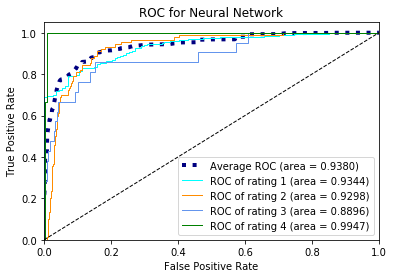

In [31]:
# Compute ROC AUC score
mlp_nn_result = compute_roc_auc_in_classes(y_test, y_pred_proba, num_classes=n_classes)

# Draw ROC plot
draw_roc_auc_in_classes(mlp_nn_result, 'Neural Network', num_classes=n_classes)

In [32]:
# Assign Best ROC value
roc_mlp_nn = mlp_nn_result['roc_auc']["macro"]
print('Best ROC score for Neural Network: {0:0.4f}'.format(roc_mlp_nn))

Best ROC score for Neural Network: 0.9380


In [33]:
# Step 7. Solve with Random Forest

In [61]:
from sklearn.ensemble import RandomForestClassifier  

# create model for multi-class and one vs rest mode
rnd_forest = OneVsRestClassifier(RandomForestClassifier(warm_start=False, oob_score=True, n_jobs=-1, random_state=1))
                                 
print('Created Random Forest')
#print("parameters: ", rnd_forest.get_params().keys())

# Create GridSearch to find best model
# Tested:
#      n_estimators_param = [ 50, 100, 200]
#      max_depth_param = [10, 20, 40]
#      max_leaf_nodes_param = [ 20, 50, 100 ]
#      max_features_param = [ 20, X_train.shape[1] ]
#      criterion_param = ['entropy', 'gini' ]
#      class_weight_param = ['balanced', 'balanced_subsample', None]
# To save time, only test partial parameters

n_estimators_param = [ 100, 200, 500]
max_depth_param = [ 10, 20, 40 ]
max_leaf_nodes_param = [ 20, 50, 100 ]
max_features_param = [ 20, X_train.shape[1] ]
criterion_param = [ 'gini' ]
class_weight_param = [ 'balanced' ]

hyperparameters = dict(estimator__n_estimators=n_estimators_param, 
                       estimator__max_depth=max_depth_param, 
                       estimator__max_leaf_nodes=max_leaf_nodes_param, 
                       estimator__max_features=max_features_param,
                       estimator__criterion=criterion_param, 
                       estimator__class_weight=class_weight_param)

# Fit model using gridsearch
score_making_func = make_scorer(roc_auc_score, average='macro')
grid_rnd_forest = GridSearchCV(rnd_forest, hyperparameters, scoring=score_making_func, verbose=0)

Created Random Forest


In [62]:
timer_check = time.time()
print('start training')

# Best model
best_rnd_forest = grid_rnd_forest.fit(X_train, y_train)

#Print all the Parameters that gave the best results:
print('Best Parameters', grid_rnd_forest.best_params_)

print('training spent: ', show_time_spent(timer_check))

# Compute test scores
y_pred_proba = best_rnd_forest.predict(X_test)
print('y_pred_proba: ', y_pred_proba.shape)

start training
Best Parameters {'estimator__class_weight': 'balanced', 'estimator__criterion': 'gini', 'estimator__max_depth': 10, 'estimator__max_features': 20, 'estimator__max_leaf_nodes': 20, 'estimator__n_estimators': 200}
training spent:  0:3:30
y_pred_proba:  (1188, 4)


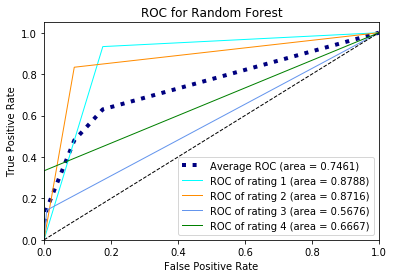

In [63]:
# Compute ROC AUC score
rnd_forest_result = compute_roc_auc_in_classes(y_test, y_pred_proba, num_classes=n_classes)

# Draw ROC plot
draw_roc_auc_in_classes(rnd_forest_result, 'Random Forest', num_classes=n_classes)

In [64]:
# Assign Best ROC value
roc_rnd_forest = rnd_forest_result['roc_auc']["macro"]
print('Best ROC score for Random Forest: {0:0.4f}'.format(roc_rnd_forest))

Best ROC score for Random Forest: 0.7461


In [65]:
# Step 7. Solve with Voting Classifier

In [70]:
# Store best results for different model
avail_models = [
    {'name': 'Logistic Regression', 'roc_auc': roc_logreg, 'model': best_logreg},
    {'name': 'Naive Bayes', 'roc_auc': roc_gaussian_proc, 'model': best_gaussian_proc},
    {'name': 'Decision Tree', 'roc_auc': roc_decision_tree, 'model': best_decision_tree},
    {'name': 'Linear SVC', 'roc_auc': roc_linear_svc, 'model': best_linear_svc},
    {'name': 'Neural Network', 'roc_auc': roc_mlp_nn, 'model': best_mlp_nn},
    {'name': 'Random Forest', 'roc_auc': roc_rnd_forest, 'model': best_rnd_forest}
]

# Sort based on ROC area values
avail_models.sort(key=lambda sortKey : sortKey['roc_auc'], reverse=True)
print([(model['name'], model['roc_auc']) for model in avail_models])

[('Naive Bayes', 0.9696011481510143), ('Decision Tree', 0.9655056642568163), ('Logistic Regression', 0.962512246150418), ('Neural Network', 0.9380210191949173), ('Linear SVC', 0.8187998675863606), ('Random Forest', 0.7461462612748613)]


In [73]:
# We will compare and choose the best 3 models to create voting classifier to estimate the results,
voting_estimators = []

for i in (0, 1, 2):
    best_model_name, best_roc_auc = (avail_models[i]['name'], avail_models[i]['roc_auc'])
    voting_estimators.append(avail_models[i]['model'])
    print('{0} - best_model_name: {1}, best_roc_auc: {2:0.4f}'.format(i, best_model_name, best_roc_auc))

0 - best_model_name: Naive Bayes, best_roc_auc: 0.9696
1 - best_model_name: Decision Tree, best_roc_auc: 0.9655
2 - best_model_name: Logistic Regression, best_roc_auc: 0.9625


In [84]:
# Since sklearn.ensemble.VotingClassifier does not support multi-class, 
# so create EnsembleClassifier to support multi-class majority voting classifier
# ref: https://sebastianraschka.com/Articles/2014_ensemble_classifier.html

from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
import numpy as np
import operator

class EnsembleClassifier(BaseEstimator, ClassifierMixin):
    """
    Ensemble classifier for scikit-learn estimators.

    Parameters
    ----------

    clf : `iterable`
      A list of scikit-learn classifier objects.
    weights : `list` (default: `None`)
      If `None`, the majority rule voting will be applied to the predicted class labels.
        If a list of weights (`float` or `int`) is provided, the averaged raw probabilities (via `predict_proba`)
        will be used to determine the most confident class label.

    """
    def __init__(self, clfs, weights=None):
        self.clfs = clfs
        self.weights = weights

    def fit(self, X, y):
        """
        Fit the scikit-learn estimators.

        Parameters
        ----------

        X : numpy array, shape = [n_samples, n_features]
            Training data
        y : list or numpy array, shape = [n_samples]
            Class labels

        """
        for clf in self.clfs:
            clf.fit(X, y)

    def predict(self, X):
        """
        Parameters
        ----------

        X : numpy array, shape = [n_samples, n_features]

        Returns
        ----------

        maj : list or numpy array, shape = [n_samples]
            Predicted class labels by majority rule

        """

        self.classes_ = np.asarray([clf.predict(X) for clf in self.clfs])
        #print("self.classes_: ", self.classes_.shape)
        #print("self.classes_[:,c]: ", self.classes_[:,0])
        #print("np.argmax(np.bincount(self.classes_[:,c])): ", np.argmax(np.bincount(self.classes_[:,0])))
        
        
        if self.weights:
            avg = self.predict_proba(X)

            maj = np.apply_along_axis(lambda x: max(enumerate(x), key=operator.itemgetter(1))[0], axis=1, arr=avg)

        else:
            maj = np.asarray([np.argmax(np.bincount(self.classes_[:,c])) for c in range(self.classes_.shape[1])])

        return maj

    def predict_proba(self, X):

        """
        Parameters
        ----------

        X : numpy array, shape = [n_samples, n_features]

        Returns
        ----------

        avg : list or numpy array, shape = [n_samples, n_probabilities]
            Weighted average probability for each class per sample.

        """
        self.probas_ = [clf.predict_proba(X) for clf in self.clfs]
        
        probas_arr = np.array(self.probas_)
        #print('probas_arr: ', probas_arr.shape)
        
        avg = np.average(self.probas_, axis=0, weights=self.weights)
        #print('avg: ', avg.shape)

        return avg
    

In [85]:
# Create customized voting classifier
voting_model = EnsembleClassifier(clfs=voting_estimators, weights=[1,1,1])

# Compute test scores
y_pred_proba = voting_model.predict_proba(X_test)
print('y_pred_proba: ', y_pred_proba.shape)

y_pred_proba:  (1188, 4)


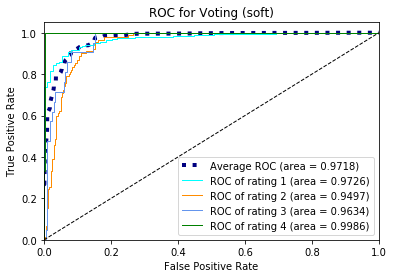

In [86]:
# Compute ROC AUC score
vt_models_result = compute_roc_auc_in_classes(y_test, y_pred_proba, num_classes=n_classes)

# Draw ROC plot
draw_roc_auc_in_classes(vt_models_result, 'Voting (soft)', num_classes=n_classes)

In [88]:
# Show final ROC value which is better than 3 best models
roc_vt_models = vt_models_result['roc_auc']["macro"]
print('Final ROC score for Voting Classifiers: {0:0.4f}'.format(roc_vt_models))

Final ROC score for Voting Classifiers: 0.9718
